In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [8]:
# --- Configuration ---
DATA_DIR = 'data'
FILE_HEALTHY = os.path.join(DATA_DIR, 'FILE 1.csv')
FILE_FAULTY = os.path.join(DATA_DIR, 'FILE 6.csv')
MODEL_SAVE_PATH = 'rf_motor_classifier.joblib'
TEST_SIZE = 0.2
RANDOM_SEED = 42
N_ESTIMATORS = 100  # Number of trees

In [9]:
# --- 1. Load Data ---
def load_data():
    print("Loading data...")
    # Read CSVs
    df_healthy = pd.read_csv(FILE_HEALTHY)
    df_faulty = pd.read_csv(FILE_FAULTY)

    # Add conditions
    df_healthy['condition'] = 0  # Healthy
    df_faulty['condition'] = 1   # Faulty

    # Concatenate
    df = pd.concat([df_healthy, df_faulty], ignore_index=True)
    
    # Shuffle
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    print(f"Total samples: {len(df)}")
    print(f"Healthy samples: {len(df_healthy)}")
    print(f"Faulty samples: {len(df_faulty)}")
    
    return df

In [ ]:
# --- 2. Train & Evaluate ---
def train_and_evaluate(df):
    feature_cols = ['x', 'y', 'Z', 'I1', 'I2', 'I3', 'V1', 'V2', 'V3']
    # feature_cols = ['I1', 'I2', 'I3', 'V1', 'V2', 'V3']

    X = df[feature_cols].values
    y = df['condition'].values

    # Split
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

    # Initialize Model
    print(f"Initializing Random Forest with {N_ESTIMATORS} trees...")
    # n_jobs=-1 uses all available cores
    clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_SEED, n_jobs=3, verbose=1)

    #print all columns
    print(df.columns) 
    # print first 5 rows for condition
    print(df['condition'].head())
    # Train
    print("Training model...")
    clf.fit(X_train, y_train)

    # Predict
    print("Evaluating model...")
    y_pred = clf.predict(X_test)

    # Metrics
    print("\nEvaluation Results:")
    print(classification_report(y_test, y_pred, target_names=['Healthy', 'Faulty']))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\n" + "="*60)
    print("Random Forest Model Summary")
    print("="*60)
    print(f"Number of Trees: {clf.n_estimators}")
    print(f"Criterion: {clf.criterion}")
    print(f"Max Depth: {clf.max_depth}")
    print(f"Min Samples Split: {clf.min_samples_split}")
    print(f"Min Samples Leaf: {clf.min_samples_leaf}")
    print(f"Bootstrap: {clf.bootstrap}")
    print(f"Class Weight: {clf.class_weight}")
    print("="*60 + "\n")

    # Feature Importance
    print("\n" + "="*60)
    print("Feature Importances")
    print("="*60)
    importances = clf.feature_importances_
    indices = importances.argsort()[::-1]
    for i in range(len(feature_cols)):
        print(f"{feature_cols[indices[i]]:<10}: {importances[indices[i]]:.4f}")
    print("="*60 + "\n")
    
    return clf, X_test, y_test, feature_cols

In [11]:
def plot_graphs(model, X_test, y_test, feature_cols):
    print("Generating graphs...")
    
    # 1. Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    print("Saved confusion_matrix.png")
    plt.show()

    # 2. ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    print("Saved roc_curve.png")
    plt.show()

    # 3. Feature Importance Plot
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(feature_cols)), importances[indices], align="center")
    plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=45)
    plt.xlim([-1, len(feature_cols)])
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Saved feature_importance.png")
    plt.show()

In [16]:

df = load_data()


Loading data...
Total samples: 2000000
Healthy samples: 1000000
Faulty samples: 1000000


In [13]:

# 2. Train & Evaluate
model, X_test, y_test, feature_cols = train_and_evaluate(df)

Splitting data...
Initializing Random Forest with 100 trees...
Index(['x', 'y', 'Z', 'I1', 'I2', 'I3', 'V1', 'V2', 'V3', 'condition'], dtype='object')
0    1
1    1
2    0
3    1
4    0
Name: condition, dtype: int64
Training model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Evaluating model...

Evaluation Results:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00    200063
      Faulty       1.00      1.00      1.00    199937

    accuracy                           1.00    400000
   macro avg       1.00      1.00      1.00    400000
weighted avg       1.00      1.00      1.00    400000

Accuracy: 1.0000

Random Forest Model Summary
Number of Trees: 100
Criterion: gini
Max Depth: None
Min Samples Split: 2
Min Samples Leaf: 1
Bootstrap: True
Class Weight: None


Feature Importances
Z         : 0.3165
x         : 0.1743
I3        : 0.1185
I1        : 0.1165
I2        : 0.1003
y         : 0.0748
V1        : 0.0395
V2        : 0.0350
V3        : 0.0246



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Generating graphs...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Saved confusion_matrix.png


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


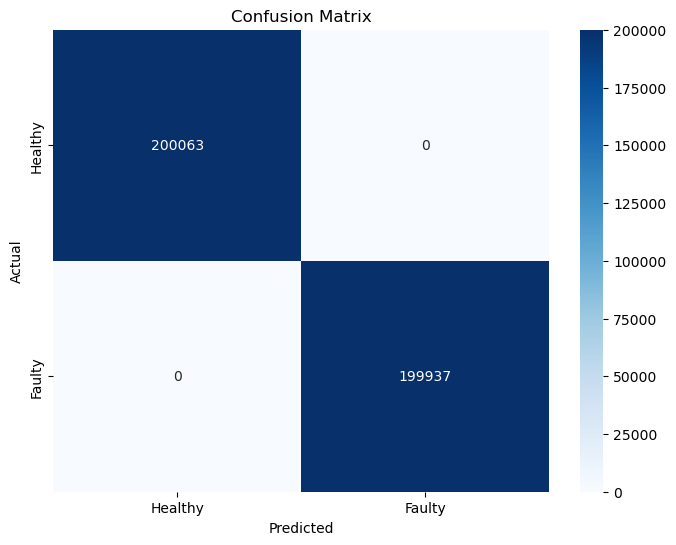

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Saved roc_curve.png


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


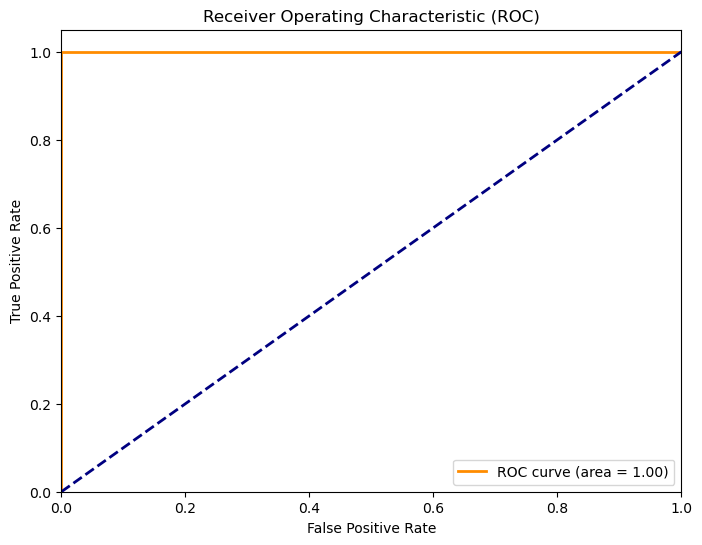

Saved feature_importance.png


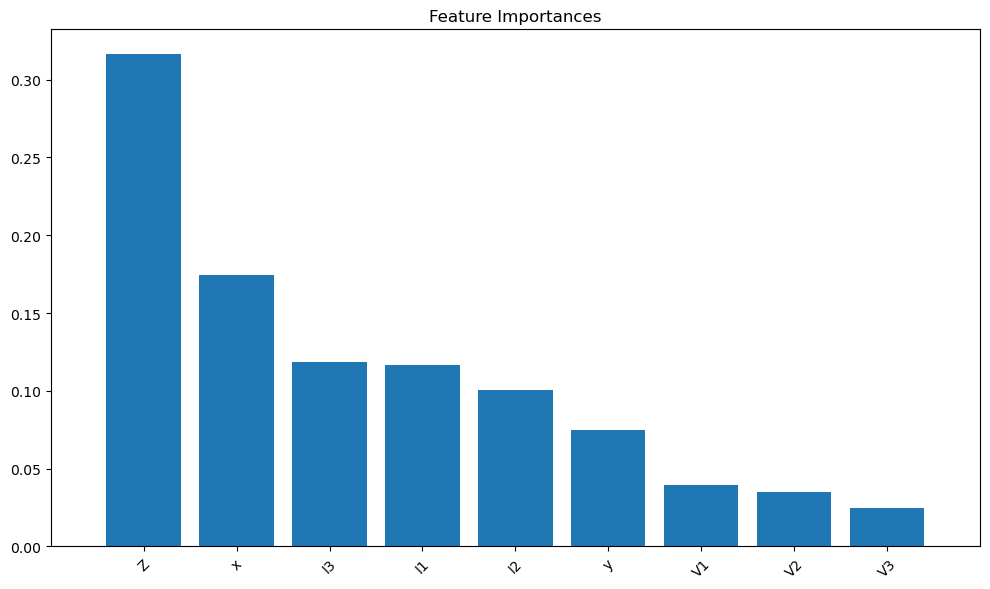

In [14]:

# 3. Plot Graphs
plot_graphs(model, X_test, y_test, feature_cols)


In [15]:

# 4. Save Model
print(f"\nSaving model to {MODEL_SAVE_PATH}...")
joblib.dump(model, MODEL_SAVE_PATH)
print("Done.")


Saving model to rf_motor_classifier.joblib...
Done.
